## O. Import

In [1]:
import pandas as pd
import numpy as np
import random
import argparse
import urllib
import csv
import os
import keras

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing import text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical
from nltk.tokenize import sent_tokenize

from tensorflow.compat.v1.keras.layers import CuDNNGRU
#from tensorflow.keras import backend as K
from tensorflow.compat.v1.keras import backend as K
from keras.engine.topology import Layer
#from tensorflow.compat.v1.keras.layers import CuDNNGRU
from keras.layers import Input, Embedding, Dense
from keras.layers import Lambda, Permute, RepeatVector, Multiply
from keras.layers import Bidirectional, TimeDistributed
from keras.layers import GRU
from keras.layers import BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
from numpy import argmax
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

In [2]:
MAX_SENTENCES = 8
MAX_SENTENCE_LENGTH = 20

## 1. Data Preprocessing

In [3]:
df = pd.read_csv('/root/corona/hatespeech/Data/data_waseem_3.csv',encoding = "ISO-8859-1")
df = df[['hate','comment']]
df = df.sample(frac=1).reset_index(drop=True)
df

,hate,comment
0,0,@halcyon2001 @kitteh09 @Oh_so_offensive . No...
1,1,RT @KanoWyatt: @jennahhhx I pay the bills in t...
2,0,@LucifersLawyer @DeadpoolPewPew @TechyFolks @S...
3,2,@Vandaliser @sajid_fairooz @IsraeliRegime Wher...
4,0,@wammezz Your demand for perfection would lead...
...,...,...
16130,0,So happy to hear #mkr playing ready to run by ...
16131,0,"What a disgraceful episode of MKR, hope kat an..."
16132,2,"@Zahoorgorsi Next step, learning to ride a bic..."
16133,0,@ashleylynch @TimofLegend It's the first time ...


In [4]:
nohate_count = len(df[df['hate'] == 0])
sexism_count = len(df[df['hate'] == 1])
racism_count = len(df[df['hate'] == 2])
print(nohate_count)
print(sexism_count)
print(racism_count)

11033
3167
1935


In [22]:
nohate = df[df.hate == 0].index
sexism = df[df.hate == 1].index
racism = df[df.hate == 2].index
print(nohate)
print(sexism)
print(racism)
type(nohate)

Int64Index([    0,     2,     4,     5,     6,     7,     8,     9,    10,
               12,
            ...
            16119, 16121, 16123, 16125, 16127, 16129, 16130, 16131, 16133,
            16134],
           dtype='int64', length=11033)
Int64Index([    1,    11,    15,    25,    30,    48,    55,    67,    69,
               76,
            ...
            16100, 16104, 16105, 16109, 16114, 16116, 16120, 16122, 16126,
            16128],
           dtype='int64', length=3167)
Int64Index([    3,    18,    20,    22,    28,    45,    51,    66,    78,
               85,
            ...
            16051, 16065, 16068, 16073, 16080, 16099, 16101, 16111, 16124,
            16132],
           dtype='int64', length=1935)


pandas.core.indexes.numeric.Int64Index

In [23]:
nohate = np.random.choice(nohate,racism_count, replace=False)
sexism = np.random.choice(sexism,racism_count, replace=False)
racism = np.random.choice(racism,racism_count, replace=False)

In [24]:
print(len(nohate))
print(len(sexism))
print(len(racism))
print(len(nohate)*0.9)
print(len(nohate)*0.1)
print((len(nohate)+len(sexism)+len(racism))*0.9)

1935
1935
1935
1741.5
193.5
5224.5


In [25]:
nohate_train = nohate[:1741]
nohate_test = nohate[1741:]
sexism_train = sexism[:1741]
sexism_test = sexism[1741:]
racism_train = racism[:1741]
racism_test = racism[1741:]

In [26]:
train = np.concatenate((nohate_train,sexism_train,racism_train))
test = np.concatenate((nohate_test,sexism_test,racism_test))

In [27]:
train_df = df.loc[train]
test_df = df.loc[test]

In [28]:
train_df

,hate,comment
547,0,@drurbanski @trentmkays i've just seen way to ...
3254,0,@edgeofthesandbx @batchelorshow @FearDept Most...
12974,0,RT @JL_Whitaker: Which will end first: #mkr or...
14030,0,@trentmkays @drurbanski https://t.co/CkX9tJ8Ay5
5657,0,@limbclock i wouldn't do that.
...,...,...
14167,2,@MaxBlumenthal @RaniaKhalek There was no Shuja...
7682,2,RT @b_kisan: @TRobinsonNewEra Same country whe...
11993,2,@SafeensS The nuns are wearing the chosen robs...
2114,2,@ZamiraTwitt Erdogan is a fascist Islamist scu...


In [29]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [30]:
train_df

,hate,comment
0,1,#mkr the only thing funnier than an upside dow...
1,0,My eyes are burning. #MKR
2,0,@ingyusarms Spirituality is the common divinit...
3,0,#MKR learn how to open cans gee
4,0,Aww yay ash and camila #mkr
...,...,...
5218,1,"RT @KhalilAOfficial First, female sports. Now ..."
5219,1,"RT @sports2inflatio: @radioclashed right!, lis..."
5220,0,@azmoderate @JoeWSJ So you admit you were wron...
5221,1,RT @NicBeardsley311: Id love to turn around an...


In [31]:
train_x_data =[]
train_y_data =[]
test_x_data =[]
test_y_data =[]


length=len(train_df)
for i in range(length):
    train_x_data.append(train_df.loc[i].comment)
    train_y_data.append(train_df.loc[i].hate)
    
length=len(test_df)
for i in range(length):
    test_x_data.append(test_df.loc[i].comment)
    test_y_data.append(test_df.loc[i].hate)


In [32]:
print("len(train_x_data): {}".format(len(train_x_data)))
print("len(test_x_data): {}".format(len(test_x_data)))

len(train_x_data): 5223
len(test_x_data): 582


In [33]:
train_x_data

["#mkr the only thing funnier than an upside down ice cream maker insert?  When my brother's ex wife admitted to burning water.",
 'My eyes are burning. #MKR',
 '@ingyusarms Spirituality is the common divinity of all things. All things being a manifestation of god.',
 '#MKR learn how to open cans gee',
 'Aww yay ash and camila #mkr',
 'RT @riwired: @shim_rational As a non-Israeli and non-Jew I stand beside you for I know the truth of this savagery against #Israel &amp; the Jew?',
 '@dankmtl Good night asshole. Hope you get run over by a bus.',
 '@hdmovieus Islam is terror.  To fight terror you have to fight Islam. Your prophet and your god are both sick terrorists. #Islam',
 '@fulaan_hazm So they have to imprison the people of Mosul and not allow them to leave. Islam is a religion of slaves and slavery.',
 '@DianH4 Perish slowly my ass. Slavery lasted longer in the Muslim world that anywhere else. And your hero is trying to bring it back.',
 'Actually u need help @purexelegance Call me

## 2. Tokenizing

In [34]:
import numpy as np
#텍스트 데이터는 전처리 과정을 통해 모델에 데이터를 정제하는 과정을 필요로함
#이러한 전처리 과정에 사용할 모듈
from tensorflow.keras.preprocessing import text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical
from nltk.tokenize import sent_tokenize
import csv
import os


tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x_data)
tokenizer.fit_on_texts(test_x_data)

max_nb_words = len(tokenizer.word_index) + 1
def doc2hierarchical(text,
                     max_sentences=MAX_SENTENCES,
                     max_sentence_length=MAX_SENTENCE_LENGTH):
    sentences = sent_tokenize(text)
    tokenized_sentences = tokenizer.texts_to_sequences(sentences)
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=max_sentence_length)

    pad_size = max_sentences - tokenized_sentences.shape[0]

    if pad_size <= 0:  # tokenized_sentences.shape[0] < max_sentences
        tokenized_sentences = tokenized_sentences[:max_sentences]
    else:
        tokenized_sentences = np.pad(
            tokenized_sentences, ((0, pad_size), (0, 0)),
            mode='constant', constant_values=0
        )
    
    return tokenized_sentences
            
def build_dataset(x_data, y_data, 
                  max_sentences=MAX_SENTENCES, 
                  max_sentence_length=MAX_SENTENCE_LENGTH,
                  tokenizer=tokenizer):
    
    nb_instances = len(x_data)
    
    
    X_data = np.zeros((nb_instances, max_sentences, max_sentence_length), dtype='int32')
    
    
    for i, review in enumerate(x_data):
        tokenized_sentences = doc2hierarchical(review)
            
        X_data[i] = tokenized_sentences[None, ...]
        
    nb_classes = len(set(y_data))
    Y_data = to_categorical(y_data, nb_classes)
    
    return X_data, Y_data


## 3. train, test data split

In [35]:
train_X_data, train_Y_data = build_dataset(train_x_data, train_y_data)
test_X_data, test_Y_data = build_dataset(test_x_data, test_y_data)

print("train_X_data.shape: {}".format(train_X_data.shape))
print("test_X_data.shape: {}".format(test_X_data.shape))

train_X_data, val_X_data, train_Y_data, val_Y_data = train_test_split(train_X_data, train_Y_data, 
                                                                      test_size=0.1111, 
                                                                      random_state=42)

print("train_X_data.shape: {}".format(train_X_data.shape))
print("train_Y_data.shape: {}".format(train_Y_data.shape))
print("val_X_data.shape: {}".format(val_X_data.shape))
print("val_Y_data.shape: {}".format(val_Y_data.shape))

train_X_data.shape: (5223, 8, 20)
test_X_data.shape: (582, 8, 20)
train_X_data.shape: (4642, 8, 20)
train_Y_data.shape: (4642, 3)
val_X_data.shape: (581, 8, 20)
val_Y_data.shape: (581, 3)


## 4. Load embedding matrix

In [36]:
embedding_dir = '/root/corona/hatespeech/embedding'

def load_word2vec(tokenizer=tokenizer):
    from gensim.models import KeyedVectors
    embedding_path = os.path.join(embedding_dir, 'GoogleNews-vectors-negative300.bin')
    embeddings_index = KeyedVectors.load_word2vec_format(embedding_path, binary=True)
    
    return embeddings_index
    
def load_embedding(embedding_type='word2vec',
                   tokenizer=tokenizer,
                   embedding_dim=300):
    
    if embedding_type == 'word2vec':
        embeddings_index = load_word2vec()
        
    embedding_matrix = np.random.normal(0, 1, (max_nb_words, embedding_dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = embeddings_index[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

embedding_matrix = load_embedding('word2vec')

print("embedding_matrix.shape: {}".format(embedding_matrix.shape))

embedding_matrix.shape: (13312, 300)


## 5. AttentionLayer 

In [38]:
tf.compat.v1.disable_eager_execution()
experimental_run_tf_function=False


class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1], self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    


In [39]:

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation
    
    


In [40]:
def HieAtt(embedding_matrix,
           max_sentences,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=50,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           optimizer = keras.optimizers.Adagrad(lr=0.01, epsilon=1e-6)):

    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sentence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sentence = embedding_layer(sentence_input)
    embedded_sentence = Dropout(dense_dropout)(embedded_sentence)
    contextualized_sentence = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_sentence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sentence)
    sentence_representation = WeightedSum(word_attention, contextualized_sentence)
    
    sentence_encoder = Model(inputs=[sentence_input], 
                             outputs=[sentence_representation])

    # then, build a document encoder
    document_input = Input(shape=(max_sentences, max_sentence_length), dtype='int32')
    embedded_document = TimeDistributed(sentence_encoder)(document_input)
    contextualized_document = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_document)
    
    # sentence attention computation
    sentence_attention = AttentionLayer(attention_dim)(contextualized_document)
    document_representation = WeightedSum(sentence_attention, contextualized_document)
    
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(document_representation)

    model = Model(inputs=[document_input],
                  outputs=[pred_sentiment])
    
    ############### build attention extractor ###############
    word_attention_extractor = Model(inputs=[sentence_input],
                                     outputs=[word_attention])
    word_attentions = TimeDistributed(word_attention_extractor)(document_input)
    attention_extractor = Model(inputs=[document_input],
                                     outputs=[word_attentions, sentence_attention])
    
    model.compile(loss=['categorical_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'])

    return model, attention_extractor




In [41]:
tf.compat.v1.disable_eager_execution()
experimental_run_tf_function=False

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1], self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation
    
    
def HieAtt(embedding_matrix,
           max_sentences,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=50,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           optimizer = keras.optimizers.Adagrad(lr=0.01, epsilon=1e-6)):

    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sentence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sentence = embedding_layer(sentence_input)
    embedded_sentence = Dropout(dense_dropout)(embedded_sentence)
    contextualized_sentence = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_sentence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sentence)
    sentence_representation = WeightedSum(word_attention, contextualized_sentence)
    
    sentence_encoder = Model(inputs=[sentence_input], 
                             outputs=[sentence_representation])

    # then, build a document encoder
    document_input = Input(shape=(max_sentences, max_sentence_length), dtype='int32')
    embedded_document = TimeDistributed(sentence_encoder)(document_input)
    contextualized_document = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_document)
    
    # sentence attention computation
    sentence_attention = AttentionLayer(attention_dim)(contextualized_document)
    document_representation = WeightedSum(sentence_attention, contextualized_document)
    
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(document_representation)

    model = Model(inputs=[document_input],
                  outputs=[pred_sentiment])
    
    ############### build attention extractor ###############
    word_attention_extractor = Model(inputs=[sentence_input],
                                     outputs=[word_attention])
    word_attentions = TimeDistributed(word_attention_extractor)(document_input)
    attention_extractor = Model(inputs=[document_input],
                                     outputs=[word_attentions, sentence_attention])
    
    model.compile(loss=['categorical_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'])

    return model, attention_extractor




## 6. Train & Save

In [42]:
save_folder = os.path.join("/root/corona/hatespeech/models")
if not os.path.isdir(save_folder):
    os.mkdir(save_folder)
model_path = os.path.join(save_folder, "modell.h5")

checkpointer = ModelCheckpoint(filepath=model_path,
                               monitor='val_acc',
                               verbose=True,
                               save_best_only=True,
                               mode='max')

model, attention_extractor = HieAtt(embedding_matrix=embedding_matrix,
                                    max_sentences=MAX_SENTENCES,
                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                    nb_classes=3,
                                    embedding_dim=300,
                                    attention_dim=100,
                                    rnn_dim=50,
                                    include_dense_batch_normalization=False,
                                    include_dense_dropout=True,
                                    nb_dense=1,
                                    dense_dim=300,
                                    dense_dropout=0.2,
                                    optimizer = keras.optimizers.Adagrad(lr=0.01, epsilon=1e-6))


history = model.fit(x=[train_X_data],
                    y=[train_Y_data],
                    batch_size=64,
                    epochs=100,
                    verbose=True,
                    validation_data=(val_X_data, val_Y_data),
                    callbacks=[checkpointer])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 4642 samples, validate on 581 samples
Epoch 1/100
4642/4642 [==============================] - 4s 781us/sample - loss: 1.1088 - accuracy: 0.3251 - val_loss: 1.1132 - val_accuracy: 0.3270
Epoch 2/100
4642/4642 [==============================] - 3s 669us/sample - loss: 1.1035 - accuracy: 0.3356 - val_loss: 1.1094 - val_accuracy: 0.3270
Epoch 3/100
4642/4642 [==============================] - 3s 667us/sample - loss: 1.1030 - accuracy: 0.3333 - val_loss: 1.0970 - val_accuracy: 0.3270
Epoch 4/100
4642/4642 [==============================] - 3s 658us/sample - loss: 1.0983 - accuracy: 0.3544 - val_loss: 1.1044 - val_accuracy: 0.3373
Epoch 5/100
4642/4642 [==============================] - 3s 668us/sample - loss: 1.1010 - accuracy: 0.3386 - val_loss: 1.0957 - val_accuracy: 0.3373
Epoch 6/1

## 7. history of accuracy & loss

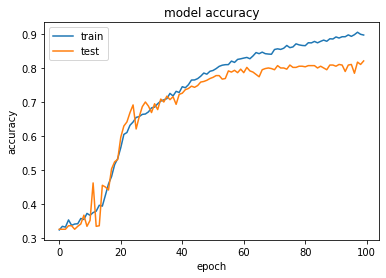

In [43]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

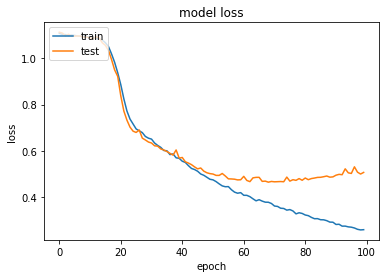

In [44]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 8. Evaluate 

In [45]:
score = model.evaluate(test_X_data, test_Y_data, verbose=0, batch_size=64)
print("Test Accuracy of {}: {}".format(model_path, score[1]))

Test Accuracy of /root/corona/hatespeech/models/modell.h5: 0.7920961976051331


In [46]:
length = len(test_x_data)
y_true = test_y_data
y_pred = []
y_predict = model.predict(test_X_data)

for i in range(length):
    y_pred.append(argmax(y_predict[i]))

target_names = ['0', '1','2']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       194
           1       0.84      0.69      0.76       194
           2       0.86      0.95      0.90       194

    accuracy                           0.79       582
   macro avg       0.79      0.79      0.79       582
weighted avg       0.79      0.79      0.79       582



In [47]:
comfmat = pd.DataFrame(confusion_matrix(y_true, y_pred), index=['nohate','sexism','racism'],columns=['nohate','sexism','racism'])
comfmat

,nohate,sexism,racism
nohate,143,26,25
sexism,55,134,5
racism,10,0,184


In [48]:
# from pandas import DataFrame
# df = DataFrame({'text': test_x_data,'true': y_true, 'predict' : y_pred})
# all_nohate = df.loc[(df['true'] == 0) & (df['predict'] == 0)]
# all_sexism = df.loc[(df['true'] == 1) & (df['predict'] == 1)]
# all_racism = df.loc[(df['true'] == 2) & (df['predict'] == 2)]

# True_nohate_Pred_sexism = df.loc[(df['true'] == 0) & (df['predict'] == 1)]
# True_nohate_Pred_racism = df.loc[(df['true'] == 0) & (df['predict'] == 2)]

# True_sexsim_Pred_nohate = df.loc[(df['true'] == 1) & (df['predict'] == 0)]
# True_sexsim_Pred_racism = df.loc[(df['true'] == 1) & (df['predict'] == 2)]

# True_racism_Pred_nohate = df.loc[(df['true'] == 2) & (df['predict'] == 0)]
# True_racism_Pred_sexism = df.loc[(df['true'] == 2) & (df['predict'] == 1)]

In [49]:

# path = './Check_result/waseem/'
# all_nohate.to_csv(path+'all_nohate.csv')
# all_sexism.to_csv(path+'all_sexism.csv')
# all_racism.to_csv(path+'all_racism.csv')

# True_nohate_Pred_sexism.to_csv(path+'True_nohate_Pred_sexism.csv')
# True_nohate_Pred_racism.to_csv(path+'True_nohate_Pred_racism.csv')

# True_sexsim_Pred_nohate.to_csv(path+'True_sexsim_Pred_nohate.csv')
# True_sexsim_Pred_racism.to_csv(path+'True_sexsim_Pred_racism.csv')

# True_racism_Pred_nohate.to_csv(path+'True_racism_Pred_nohate.csv')
# True_racism_Pred_sexism.to_csv(path+'True_racism_Pred_sexism.csv')

## 9. Attention Visualization

In [50]:
word_rev_index={}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word

def sentiment_analysis(review):        
    tokenized_sentences = doc2hierarchical(review)
    
    # word attention만 가져오기
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]
    sent_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[1][0]
    print(sent_attention)
    sent_att_labels=[]
    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
        sent_len = sent_idx
        sent_att_labels.append("Sentance "+str(sent_idx+1))
    sent_att = sent_attention[0:sent_len+1]
    sent_att = np.expand_dims(sent_att, axis=0)
    sent_att_labels = np.expand_dims(sent_att_labels, axis=0) 

    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
        
        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
                pred_att = pred_attention[sent_idx][-len(words):]
                pred_att = np.expand_dims(pred_att, axis=0)
                break


        fig, ax = plt.subplots(figsize=(1,1))
        plt.rc('xtick', labelsize=16)
        #cmap="Blues",cmap='YlGnBu"
        heatmap = sns.heatmap([[sent_att[0][sent_idx]]], xticklabels=False, yticklabels=False,cbar = False , annot=[[sent_att_labels[0][sent_idx]]],fmt ='', square=True, linewidths=0.1, cmap='coolwarm', center=0, vmin=0, vmax=1)
        plt.xticks(rotation=45)
        plt.show()
        
        
        
        fig, ax = plt.subplots(figsize=(len(words), 2))
        plt.rc('xtick', labelsize=16)
        pred_att
        word_list = np.expand_dims(words, axis=0)
        heatmap = sns.heatmap(pred_att, xticklabels=False, yticklabels=False,cbar=False, square=True,annot=word_list ,fmt ='', annot_kws={"alpha":1,'rotation':15},cmap ="coolwarm_r", linewidths=0.2, center=0, vmin=0, vmax=1)
        plt.xticks(rotation=45)
        plt.show()

[0.16265887 0.39084247 0.2936715  0.13190366 0.00851803 0.00450313
 0.0038025  0.0040999 ]


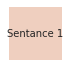

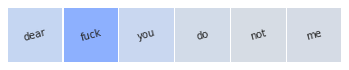

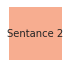

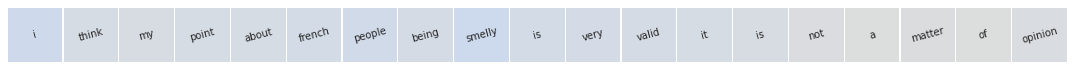

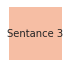

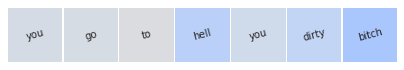

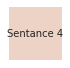

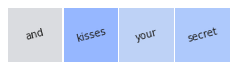

In [51]:
text =  "== Dear Yandman == Fuck you, do not censor me, cuntface. I think my point about French people being smelly frogs is very valid, it is not a matter of opinion. You go to hell you dirty bitch. Hugs and kisses Your secret admirer "
sentiment_analysis(text)